In [2]:
#Generic part which contains classes and initialization code
#used for training and for testing
import gymnasium as gym
import random
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
%matplotlib inline
from collections import namedtuple, deque
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    

def hidden_init(layer):
    """ calculate initialising values for Linear layers"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
class Actor(nn.Sequential):
    def __init__(self, n_observations, n_hidden, n_hidden2, n_actions, seed):
        if True:
            super(Actor, self).__init__(
            nn.Linear(n_observations, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden2),
            nn.ReLU(),
            nn.Linear(n_hidden2, n_actions),
            nn.Tanh())
        self.reset_parameters()
    def reset_parameters(self):
        was_last=False
        for child in reversed(list(self.children())):
            if type(child) == nn.Linear:
                if was_last:
                    child.weight.data.uniform_(*hidden_init(child))
                else:
                    child.weight.data.uniform_(-3e-3, 3e-3)
                    was_last=True
            print(child)
            
#Actor and critic networks have different architectures, so different classes are used
        
class Critic(nn.Module):
    def __init__(self, n_observations, n_hidden, n_hidden2, n_actions,seed):
        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(n_observations, n_hidden)
        self.fc2 = nn.Linear(n_hidden+n_actions,  n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_actions)
        self.reset_parameters()
    def reset_parameters(self):
        was_last=False
        for child in reversed(list(self.children())):
            if type(child) == nn.Linear:
                if was_last:
                    child.weight.data.uniform_(*hidden_init(child))
                else:
                    child.weight.data.uniform_(-3e-3, 3e-3)
                    was_last=True
            print(child)
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
        

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.nep=0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size,128,100, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size,128,100, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size,128,100, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size,128,100, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #all values are converted to Tensors
        self.memory.add(torch.tensor([state], device=device, dtype = torch.float32),
                         torch.tensor([action], device=device, dtype = torch.float32),
                         torch.tensor([next_state], device=device, dtype = torch.float32),
                         torch.tensor([reward], device=device, dtype = torch.float32),
                         torch.tensor([float(done)], device=device, dtype = torch.float32))

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            ns = self.noise.sample()
            action += ns*math.exp(-1*800/(self.nep+1)) #decreasing noise impact in time, maybe values should be adjusted
            self.nep+=1
        return np.clip(action, -1, 1)   #Tanh gives us range from -1 to 1 so we clipping to this range too,
                                        #scaling will be later

    def reset(self):
        self.noise.reset()
        self.nep=0

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, next_state, reward,  done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size) #getting batch sample
        
        #converting list of experiences to ready for use Tensors
        states = torch.vstack([e.state for e in experiences if e is not None]).float().to(device)
        actions = torch.vstack([e.action for e in experiences if e is not None]).float().to(device)
        rewards = torch.vstack([e.reward for e in experiences if e is not None]).float().to(device)
        next_states = torch.vstack([e.next_state for e in experiences if e is not None]).float().to(device)
        dones = torch.vstack([e.done for e in experiences if e is not None]).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)



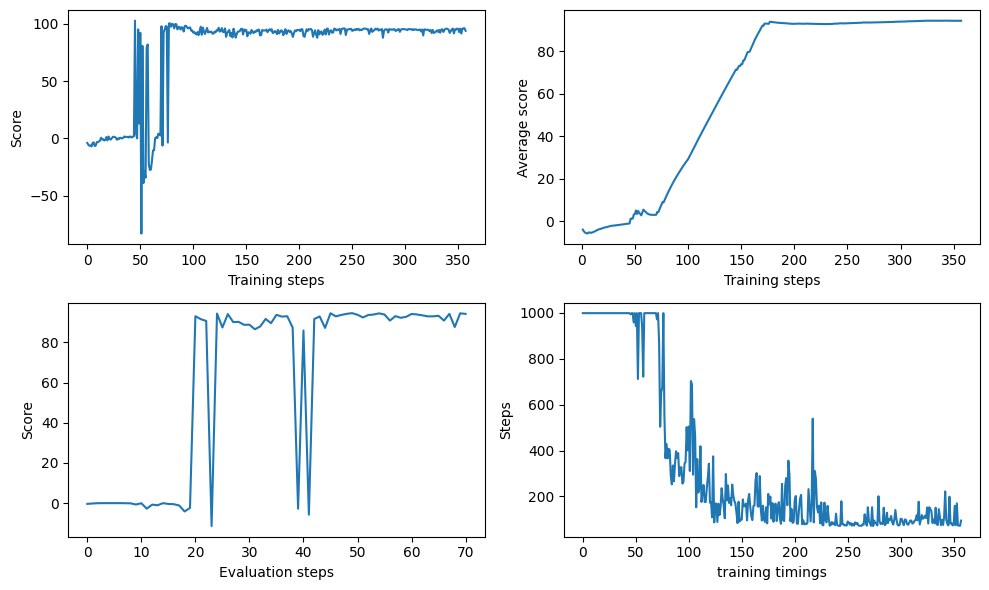

In [6]:
#Training code  - allows to save trained checkpoint for late reuse
#Existing checkpoinst will be OVERWRITTEN
env = gym.make('MountainCarContinuous-v0')# no render fo speed up training process
agent = Agent(state_size=2, action_size=1, random_seed=5)
scrs1 = [] #training scores
scrs2 = [] # mean trainig scores on step n
scrse = [] # evaluation scores for testing
timings = []
plt.ion() #interactive plot for training process visualising
def plot_rewards(rewards, avg,evals, timings):
    """ Function for creating plots, trainig reward plot, training average plot and eval plot(not every step) """
    plt.figure(1)
    plt.clf()
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    axes[0,0].plot(rewards)
    axes[0,0].set_xlabel("Training steps")
    axes[0,0].set_ylabel("Score")
    axes[0,1].set_xlabel("Training steps")
    axes[0,1].set_ylabel("Average score")
    axes[0,1].plot(avg)
    axes[1,0].plot(evals)
    axes[1,0].set_xlabel("Evaluation steps")
    axes[1,0].set_ylabel("Score")
    axes[1,1].plot(timings)
    axes[1,1].set_xlabel("training timings")
    axes[1,1].set_ylabel("Steps")
    fig.tight_layout()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def ddpg(n_episodes=900, max_t=999, print_every=100): #printing accuracy not work correctly with interactive plots
    scores_deque = deque(maxlen=print_every)
    scores=[]
    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        agent.reset()
        score = 0 
        time = 0
        score_e=0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action) # 
            reward += 0.7*abs(next_state[1])
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            time +=1
            if done:
                break
        if i_episode % (5) == 0: #evaluation step performed every 20 steps to check how it's work without noise applying
            state = env.reset()[0]
            for t in range(250):
                action = agent.act(state, add_noise=False)
                env.render()
                state, reward, done,truncated,_ = env.step(action)
                score_e += reward
                if done or truncated:
                    break 
            scrse.append(score_e)
        scrs1.append(score)
        scrs2.append(np.mean(scores_deque))
        timings.append(time)
        plot_rewards(scrs1, scrs2, scrse, timings)
        scores_deque.append(score)
        #scores.append(score)
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        try:  #saving checkpoints for neural nets, not necessary for every step, but such way is more simple
            torch.save(agent.actor_local.state_dict(), 'checkpoint_DDPG_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_DDPG_critic.pth')
        except: #sometimes saving is not successful, so, try clause is required
            print("error saving")
                
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Testing part with rendering
env = gym.make('MountainCarContinuous-v0', render_mode="human")
agent = Agent(state_size=2, action_size=1, random_seed=5)
agent.actor_local.load_state_dict(torch.load('checkpoint_DDPG_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_DDPG_critic.pth'))
while True:
    state = env.reset()[0]
    rewards = 0
    for t in range(999):
        action = agent.act(state, add_noise=False)
        env.render()
        state, reward, done,truncated,_ = env.step(action)
        rewards += reward
        if done or truncated:
            print(f'Reward is: {rewards}')
            break 

env.close()